In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from scipy import sparse
import warnings
warnings.filterwarnings('ignore')



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/My Drive/Dataset/9_Donors_choose_DT/preprocessed_data.csv')

In [4]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [5]:
#importing nltk SentimentIntensityAnalyzer to analysis sentiment values
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#creating instance for SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [6]:
#getting essay values from dataset
e = data['essay'].values

In [7]:
#calculate sentiment values for essay and sum and store in list using list comprehensive
lst = [sum(sid.polarity_scores(e[i]).values()) for i in range(len(data))]

In [8]:
#adding new column to dataset as po contains sum of sentiment values
data['po'] = np.array(lst)

In [9]:
#define x and y values
x = data.drop(['project_is_approved'], axis=1)
y = data['project_is_approved'].values

In [10]:
#splitting data to train and test using train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, stratify = y)

In [11]:
#create tfidfvectorizer with below parameters to encode essay
from sklearn.feature_extraction.text import TfidfVectorizer
TF = TfidfVectorizer(min_df=10, ngram_range=(1,4), max_features=2500)

#fit using train data
TF.fit(x_train['essay'].values)

#Transform train and test esaay values
x_train_essay_tfidf = TF.transform(x_train['essay'].values)
x_test_essay_tfidf = TF.transform(x_test['essay'].values)

In [12]:
#encoding school state
vectorizer = CountVectorizer()
vectorizer.fit(x_train['school_state'].values)

x_train_state_ohe = vectorizer.transform(x_train['school_state'].values)
x_test_state_ohe = vectorizer.transform(x_test['school_state'].values)

In [13]:
#encoding teacher prefix
vectorizer = CountVectorizer()
vectorizer.fit(x_train['teacher_prefix'].values)

x_train_teacher_ohe = vectorizer.transform(x_train['teacher_prefix'].values)
x_test_teacher_ohe = vectorizer.transform(x_test['teacher_prefix'].values)

In [14]:
#encoding grade
vectorizer = CountVectorizer()
vectorizer.fit(x_train['project_grade_category'].values)

x_train_grade_ohe = vectorizer.transform(x_train['project_grade_category'].values)
x_test_grade_ohe = vectorizer.transform(x_test['project_grade_category'].values)

In [15]:
#encoding price
#price is numerical feature so we are using normalizer
normalizer = Normalizer()
normalizer.fit(x_train['price'].values.reshape(-1,1))

x_train_price_norm = normalizer.transform(x_train['price'].values.reshape(-1,1))
x_test_price_norm = normalizer.transform(x_test['price'].values.reshape(-1,1))

In [16]:
#encoding teacher_number_of_previously_posted_projects
#teacher_number_of_previously_posted_projects is numerical feature so we are using normalizer
normalizer = Normalizer()
normalizer.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

x_train_nopp_ohe = normalizer.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
x_test_nopp_ohe = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [17]:
#encoding clean_categories
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_categories'].values)

x_train_cat_ohe = vectorizer.transform(x_train['clean_categories'].values)
x_test_cat_ohe = vectorizer.transform(x_test['clean_categories'].values)

In [18]:
#encoding clean_subcategories
vectorizer = CountVectorizer()
vectorizer.fit(x_train['clean_subcategories'].values)

x_train_subcat_ohe = vectorizer.transform(x_train['clean_subcategories'].values)
x_test_subcat_ohe = vectorizer.transform(x_test['clean_subcategories'].values)

In [19]:
#encoding po
#po is numerical feature so we are using normalizer
normalizer = Normalizer()
normalizer.fit(x_train['po'].values.reshape(-1,1))

x_train_po_norm = normalizer.transform(x_train['po'].values.reshape(-1,1))
x_test_po_norm = normalizer.transform(x_test['po'].values.reshape(-1,1))

In [ ]:
x_train_essay_tfidf.shape

(73196, 2500)

In [54]:
#merging all encoded features into one using horizontal stacking
x_tr = hstack((x_train_essay_tfidf, x_train_state_ohe, x_train_teacher_ohe, x_train_grade_ohe, x_train_price_norm, x_train_nopp_ohe, x_train_cat_ohe, x_train_subcat_ohe)).tocsr()
x_te = hstack((x_test_essay_tfidf, x_test_state_ohe, x_test_teacher_ohe, x_test_grade_ohe, x_test_price_norm, x_test_nopp_ohe, x_test_cat_ohe, x_test_subcat_ohe)).tocsr()

In [ ]:
#creating instance for DecisionTreeClassifier
DT = DecisionTreeClassifier()

#setting parameters for hyperparameters tuning
param = {'max_depth' : [1, 5, 10, 50], 'min_samples_split' : [5, 10, 100, 500]}

#Hyperparameter tuning using RandomizedSearchCV
rs1 = RandomizedSearchCV(DT, param_distributions = param, cv=5, n_jobs=-1, return_train_score=True, scoring='roc_auc')

#fit with train data
rs1.fit(x_tr, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [ ]:
#getting best parameters and best score of model
print(rs1.best_params_)
print(rs1.best_score_)
print(param['max_depth'])

{'min_samples_split': 500, 'max_depth': 10}
0.6286057802606817
[1, 5, 10, 50]


In [ ]:
#getting total result of model
result = pd.DataFrame.from_dict(rs1.cv_results_)

In [ ]:
#getting train and test AUC from result
train_auc= result['mean_train_score']
test_auc = result['mean_test_score']
print("Test Data AUC ", test_auc)

Test Data AUC  0    0.549005
1    0.549005
2    0.601162
3    0.601380
4    0.555788
5    0.549005
6    0.628606
7    0.600793
8    0.524144
9    0.603281
Name: mean_test_score, dtype: float64


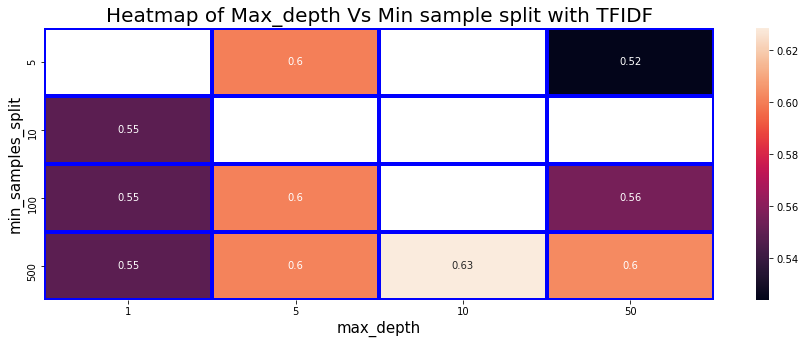

In [ ]:
pi = result.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
plt.figure(figsize=(15,5))
sns.heatmap(pi, annot=True, linecolor='blue', linewidths=3)
plt.title('Heatmap of Max_depth Vs Min sample split with TFIDF', fontsize = 20) # title with fontsize 20
plt.xlabel('max_depth', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('min_samples_split', fontsize = 15) # y-axis label with fontsize 15
plt.show()

In [ ]:
#creating best model for DecisionTreeClassifier with best parameters
DT1 = DecisionTreeClassifier(max_depth = rs1.best_params_.get('max_depth'), min_samples_split = rs1.best_params_.get('min_samples_split'))
#DT1 = DecisionTreeClassifier(max_depth = 5, min_samples_split = 500)

#fit with training data
DT1.fit(x_tr, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
#predicting probability values for train and test data
y_train_pred_prob = DT1.predict_proba(x_tr)[:,1]
y_test_pred_prob = DT1.predict_proba(x_te)[:,1]

#finding false positive rate and true positive rate for train and test data
tr_fpr1, tr_tpr1, tr_thershold1 = roc_curve(y_train, y_train_pred_prob)
te_fpr1, te_tpr1,te_threshold1 = roc_curve(y_test, y_test_pred_prob)

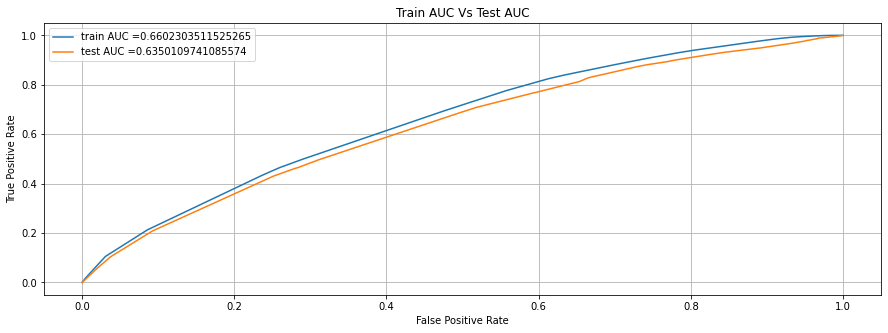

In [ ]:
#plotting ROC_AUC curve for train and test data
plt.figure(figsize=(15,5))
plt.plot(tr_fpr1, tr_tpr1, label="train AUC ="+str(auc(tr_fpr1, tr_tpr1)))
plt.plot(te_fpr1, te_tpr1, label="test AUC ="+str(auc(te_fpr1, te_tpr1)))
plt.title('Train AUC Vs Test AUC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#predicting y values for train and test data
y_train_pred = DT1.predict(x_tr)
y_test_pred = DT1.predict(x_te)

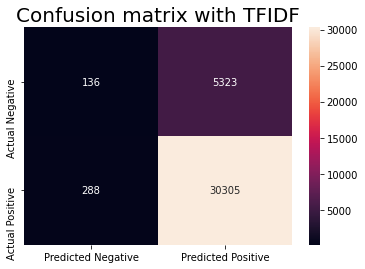

In [ ]:
#Heatmap confusion matrix between actual y_test and predicted y_test values
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion matrix with TFIDF', fontsize = 20)
plt.show()

In [ ]:
#adding actual test data y values and predicted test data y values to test data
x_test['y_test'] = y_test
x_test['y_test_pred'] = y_test_pred

In [ ]:
#calculate false positive using test data
x_fp = x_test.loc[(x_test['y_test'] == 0) & (x_test['y_test_pred'] == 1)]

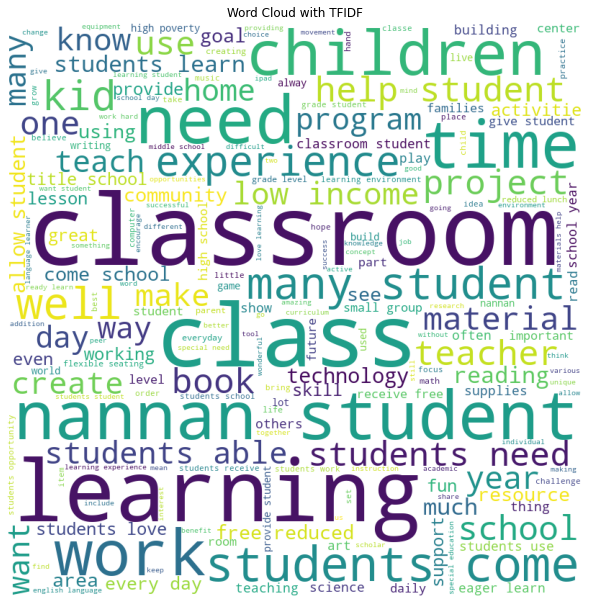

In [ ]:
from wordcloud import WordCloud, STOPWORDS
e = x_fp['essay'].values
cmmt_words = ''
stopwords = set(STOPWORDS)
for row in e:
  row = str(row)
  word = row.split()
  for i in range(len(word)):
    word[i] = word[i].lower()
  cmmt_words += " ".join(word)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords=stopwords, min_font_size=10).generate(cmmt_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud with TFIDF')
plt.show()


Text(0.5, 1.0, 'Box plot of Price with TFIDF')

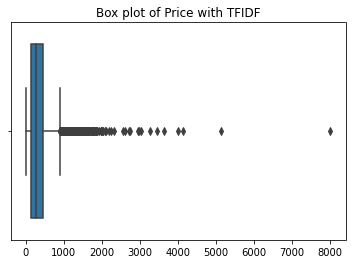

In [ ]:
#Boxplot of false positive price values
sns.boxplot(x_fp['price'].values, orient='h').set_title('Box plot of Price with TFIDF')

Text(0.5, 1.0, 'Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF')

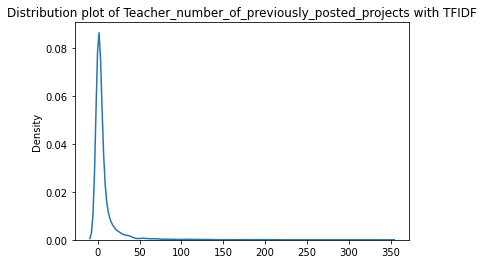

In [ ]:
#Distribution plot for teacher_number_of_previously_posted_projects using false positive test data
sns.distplot(x_fp['teacher_number_of_previously_posted_projects'].values, hist=False).set_title('Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF')

In [20]:
with open('/content/drive/My Drive/Dataset/9_Donors_choose_DT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [21]:
#calculating TFIDF-W2V
#getting train essay values
ee = x_train['essay'].values

#create empty list
res_tr = []
#iterating through each sentance in essay
for i in tqdm(range(len(ee))):
  #initialize numerator and denominator values to zero
  nume = deno = 0
  #iterating through each words in sentence
  for words in ee[i].split():
    #if word present in glove words get its TFIDF values from TF_dictionary and multiply with its 300_dim vector representation and store in numerator
    if words in glove_words:
      tfidf = (ee[i].count(words) / len(ee[i].split())) * (TF.vocabulary_.get(words, 0))
      nume += (tfidf * model[words])
      #summing the TFIDF values of each words and store it in denominator
      deno += tfidf

  #divide numerator and denominator and append to list
  res_tr.append(nume / deno)

#convert list to numpy array
x_train_essay_tfidfw2v = np.array(res_tr)

100%|██████████| 73196/73196 [03:14<00:00, 376.47it/s]


In [22]:
#calculating TFIDF-W2V
#getting train essay values
te = x_test['essay'].values

#create empty list
res_te = []
#iterating through each sentance in essay
for i in tqdm(range(len(te))):
  #initialize numerator and denominator values to zero
  nume = deno = 0
  #iterating through each words in sentence
  for words in te[i].split():
    #if word present in glove words get its TFIDF values from TF_dictionary and multiply with its 300_dim vector representation and store in numerator
    if words in glove_words:
      tfidf_te = (te[i].count(words) / len(te[i].split())) * (TF.vocabulary_.get(words, 0))
      nume += (tfidf_te * model[words])
      #summing the TFIDF values of each words and store it in denominator
      deno += tfidf_te

  #divide numerator and denominator and append to list
  res_te.append(nume / deno)

#convert list to numpy array
x_test_essay_tfidfw2v = np.array(res_te)

100%|██████████| 36052/36052 [01:36<00:00, 374.32it/s]


In [ ]:
x_train_essay_tfidfw2v.shape, x_train_state_ohe.shape, x_train_teacher_ohe.shape, x_train_grade_ohe.shape, x_train_price_norm.shape, x_train_nopp_ohe.shape, x_train_cat_ohe.shape, x_train_subcat_ohe.shape

((73196, 300),
 (73196, 51),
 (73196, 5),
 (73196, 4),
 (73196, 1),
 (73196, 1),
 (73196, 9),
 (73196, 30))

In [ ]:
# #merging all encoded features into one using horizontal stacking
# x_tr2 = sparse.csr_matrix(np.hstack((x_train_essay_tfidfw2v, x_train_state_ohe, x_train_teacher_ohe, x_train_grade_ohe, x_train_price_norm, x_train_nopp_ohe, x_train_cat_ohe, x_train_subcat_ohe)))
# x_te2 = sparse.csr_matrix(np.hstack((x_test_essay_tfidfw2v, x_test_state_ohe, x_test_teacher_ohe, x_test_grade_ohe, x_test_price_norm, x_test_nopp_ohe, x_test_cat_ohe, x_test_subcat_ohe)))

In [23]:
#merging all encoded features into one using horizontal stacking
x_tr2 = hstack((x_train_essay_tfidfw2v, x_train_state_ohe, x_train_teacher_ohe, x_train_grade_ohe, x_train_price_norm, x_train_nopp_ohe, x_train_cat_ohe, x_train_subcat_ohe)).tocsr()
x_te2 = hstack((x_test_essay_tfidfw2v, x_test_state_ohe, x_test_teacher_ohe, x_test_grade_ohe, x_test_price_norm, x_test_nopp_ohe, x_test_cat_ohe, x_test_subcat_ohe)).tocsr()

In [28]:
#creating instance for DecisionTreeClassifier
DT2 = DecisionTreeClassifier()

#setting parameters for hyperparameters tuning
param = {'max_depth' : [1, 5, 10, 50], 'min_samples_split' : [5, 10, 100, 500]}

#Hyperparameter tuning using RandomizedSearchCV
rs2 = RandomizedSearchCV(DT2, param_distributions = param, cv=5, n_jobs=-1, return_train_score=True, scoring='roc_auc')

#fit with train data
rs2.fit(x_tr2, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [29]:
#getting best parameters and best score of model
print(rs2.best_params_)
print(rs2.best_score_)
print(param['max_depth'])

{'min_samples_split': 500, 'max_depth': 5}
0.5814318868360762
[1, 5, 10, 50]


In [30]:
#getting total result of model
result2 = pd.DataFrame.from_dict(rs2.cv_results_)

In [31]:
#getting train and test AUC from result
train_auc2= result2['mean_train_score']
test_auc2 = result2['mean_test_score']
print("Test Data AUC ", test_auc2)

Test Data AUC  0    0.561178
1    0.581432
2    0.511496
3    0.564500
4    0.581346
5    0.533768
6    0.560978
7    0.574267
8    0.533768
9    0.509139
Name: mean_test_score, dtype: float64


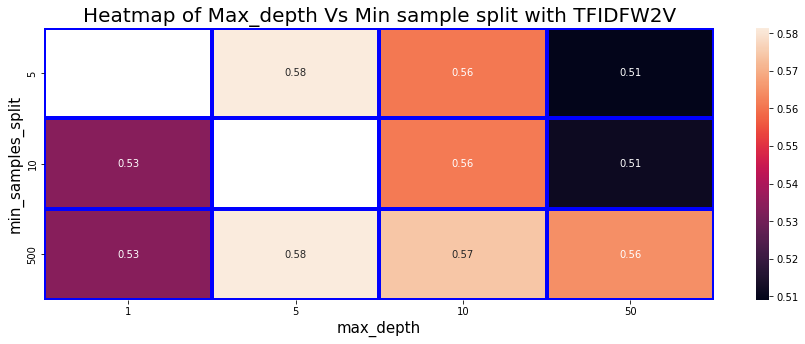

In [33]:
pi2 = result2.pivot('param_min_samples_split', 'param_max_depth', 'mean_test_score')
plt.figure(figsize=(15,5))
sns.heatmap(pi2, annot=True, linecolor='blue', linewidths=3)
plt.title('Heatmap of Max_depth Vs Min sample split with TFIDFW2V', fontsize = 20) # title with fontsize 20
plt.xlabel('max_depth', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('min_samples_split', fontsize = 15) # y-axis label with fontsize 15
plt.show()

In [49]:
#creating best model for DecisionTreeClassifier with best parameters
DT2 = DecisionTreeClassifier(max_depth = 6, min_samples_split = rs2.best_params_.get('min_samples_split')) #rs2.best_params_.get('max_depth')

#fit with training data
DT2.fit(x_tr2, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
#predicting probability values for train and test data
y_train_pred_prob = DT2.predict_proba(x_tr2)[:,1]
y_test_pred_prob = DT2.predict_proba(x_te2)[:,1]

#finding false positive rate and true positive rate for train and test data
tr_fpr2, tr_tpr2, tr_thershold2 = roc_curve(y_train, y_train_pred_prob)
te_fpr2, te_tpr2,te_threshold2 = roc_curve(y_test, y_test_pred_prob)

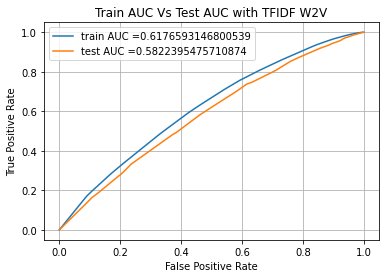

In [51]:
#plotting ROC_AUC curve for train and test data
plt.figure(figsize=(15,5))
plt.plot(tr_fpr2, tr_tpr2, label="train AUC ="+str(auc(tr_fpr2, tr_tpr2)))
plt.plot(te_fpr2, te_tpr2, label="test AUC ="+str(auc(te_fpr2, te_tpr2)))
plt.title('Train AUC Vs Test AUC with TFIDF W2V')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [52]:
#predicting y values for train and test data
y_train_pred = DT2.predict(x_tr2)
y_test_pred = DT2.predict(x_te2)

Text(0.5, 1.0, 'Confusion matrix with TFIDF-W2V')

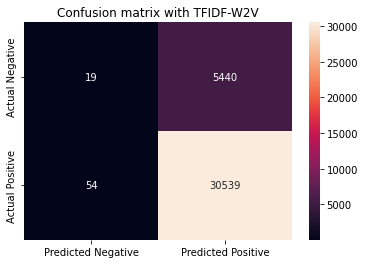

In [53]:
#Heatmap confusion matrix between actual y_test and predicted y_test values
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion matrix with TFIDF-W2V')

In [ ]:
#adding actual test data y values and predicted test data y values to test data
x_test['y_test'] = y_test
x_test['y_test_pred'] = y_test_pred

In [ ]:
#calculate false positive using test data
x_fp = x_test.loc[(x_test['y_test'] == 0) & (x_test['y_test_pred'] == 1)]

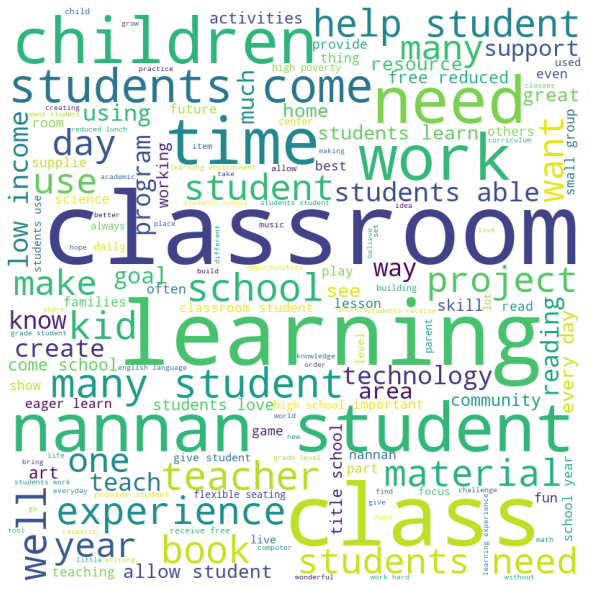

In [ ]:
from wordcloud import WordCloud, STOPWORDS
e = x_fp['essay'].values
cmmt_words = ''
stopwords = set(STOPWORDS)
for row in e:
  row = str(row)
  word = row.split()
  for i in range(len(word)):
    word[i] = word[i].lower()
  cmmt_words += " ".join(word)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords=stopwords, min_font_size=10).generate(cmmt_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud with TFIDF-W2V')
plt.show()


Text(0.5, 1.0, 'Box plot of Price with TFIDF-W2V')

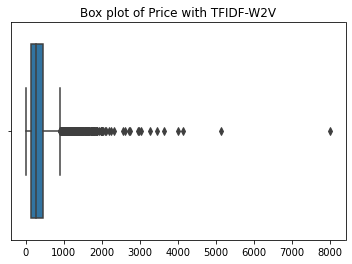

In [ ]:
#Boxplot of false positive price values
sns.boxplot(x_fp['price'].values, orient='v').set_title('Box plot of Price with TFIDF-W2V')

Text(0.5, 1.0, 'Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF-W2V')

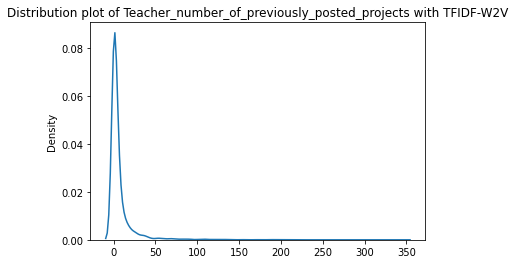

In [ ]:
#Distribution plot for teacher_number_of_previously_posted_projects using false positive test data
sns.distplot(x_fp['teacher_number_of_previously_posted_projects'].values, hist=False).set_title('Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF-W2V')

<h1>Task -2</h1>

In [55]:
#creating instance for DecisionTreeClassifier
DTF = DecisionTreeClassifier()

#setting parameters for hyperparameters tuning
param = {'min_samples_split' : [5, 10, 100, 500]}

#Hyperparameter tuning using RandomizedSearchCV
rsf = RandomizedSearchCV(DTF, param_distributions = param, cv=5, n_jobs=-1, return_train_score=True, scoring='roc_auc', verbose=1)

#fit with train data
rsf.fit(x_tr, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [56]:
#creating model for DecisionTreeClassifier with best parameters
DTF = DecisionTreeClassifier(min_samples_split = rsf.best_params_.get('min_samples_split'))

#fit with training data
DTF.fit(x_tr, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [76]:
rsf.best_params_.get('min_samples_split'), rsf.best_score_

(500, 0.5754178718710101)

In [57]:
#getting important features from model
FI = DTF.feature_importances_

In [58]:
#getting only non-zero important features
n = np.where(FI > 0)

In [59]:
#getting 1st important feature from both train and test data
x_trfi = x_tr[:, n[0]]
x_tefi = x_te[:, n[0]]

In [78]:
#creating model for DecisionTreeClassifier with best parameters
DT = DecisionTreeClassifier(min_samples_split = rsf.best_params_.get('min_samples_split'), max_depth=6)

#fit the model with train data having 1st important feature
DT.fit(x_trfi, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [79]:
x_trfi.shape, x_tefi.shape

((73196, 1593), (36052, 1593))

In [80]:
#predicting probability values for train and test data
y_train_pred_prob = DT.predict_proba(x_trfi)[:,1]
y_test_pred_prob = DT.predict_proba(x_tefi)[:,1]

#finding false positive rate and true positive rate for train and test data
tr_fpr3, tr_tpr3, tr_thershold = roc_curve(y_train, y_train_pred_prob)
te_fpr3, te_tpr3,te_threshold = roc_curve(y_test, y_test_pred_prob)

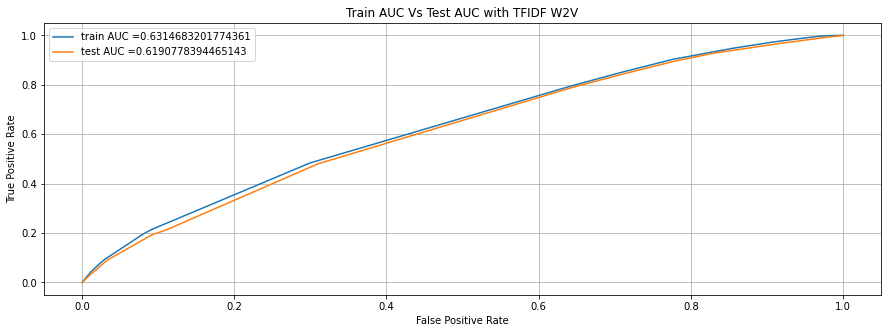

In [81]:
#plotting ROC_AUC curve for train and test data
plt.figure(figsize=(15,5))
plt.plot(tr_fpr3, tr_tpr3, label="train AUC ="+str(auc(tr_fpr3, tr_tpr3)))
plt.plot(te_fpr3, te_tpr3, label="test AUC ="+str(auc(te_fpr3, te_tpr3)))
plt.title('Train AUC Vs Test AUC with TFIDF W2V')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

In [82]:
#predicting y values for train and test data
y_train_pred = DT.predict(x_trfi)
y_test_pred = DT.predict(x_tefi)

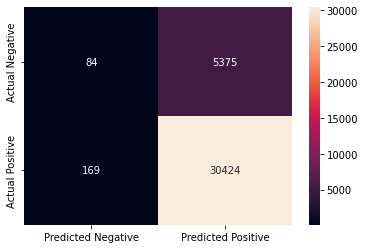

In [83]:
#Heatmap confusion matrix between actual y_test and predicted y_test values
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(y_test, y_test_pred))
sns.heatmap(cm, annot=True, fmt = 'd', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])

In [84]:
#adding actual test data y values and predicted test data y values to test data
x_test['y_test'] = y_test
x_test['y_test_pred'] = y_test_pred

In [85]:
#calculate false positive using test data
x_fp = x_test.loc[(x_test['y_test'] == 0) & (x_test['y_test_pred'] == 1)]

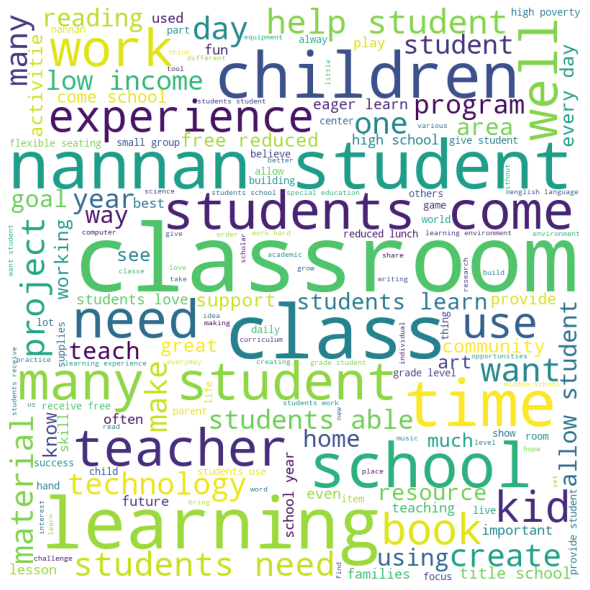

In [86]:
from wordcloud import WordCloud, STOPWORDS
e = x_fp['essay'].values
cmmt_words = ''
stopwords = set(STOPWORDS)
for row in e:
  row = str(row)
  word = row.split()
  for i in range(len(word)):
    word[i] = word[i].lower()
  cmmt_words += " ".join(word)+" "
wordcloud = WordCloud(width = 800, height = 800, background_color = 'white', stopwords=stopwords, min_font_size=10).generate(cmmt_words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()


Text(0.5, 1.0, 'Box plot of Price with TFIDF-W2V with FI')

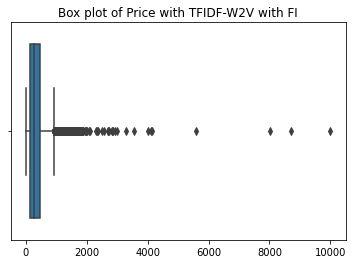

In [92]:
#Boxplot of false positive price values
sns.boxplot(x_fp['price'].values, orient='v').set_title('Box plot of Price with TFIDF-W2V with FI')

Text(0.5, 1.0, 'Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF-W2V')

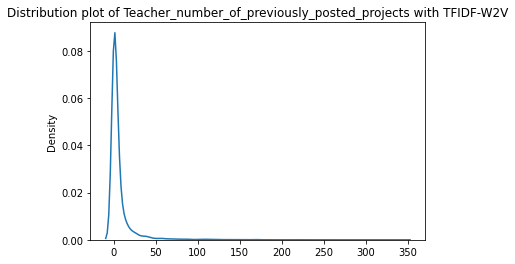

In [93]:
#Distribution plot for teacher_number_of_previously_posted_projects using false positive test data
sns.distplot(x_fp['teacher_number_of_previously_posted_projects'].values, hist=False).set_title('Distribution plot of Teacher_number_of_previously_posted_projects with TFIDF-W2V(FI)')

In [91]:
from prettytable import PrettyTable
x=PrettyTable()

x.field_names=['Vectorizer', 'Model', 'Hyperparameter', 'AUC']
# x.add_row(['Random Search-TFIDF', "DT", len(rs1.best_params_.keys()), round(rs1.best_score_,3)])
# x.add_row(['TFIDF', "DT", len(rs1.best_params_.keys()), round(auc(te_fpr1, te_tpr1), 3)])
# x.add_row(['Random Search-TFIDFW2V', "DT", len(rs2.best_params_.keys()), round(rs2.best_score_,3)])
# x.add_row(['TFIDFW2V', "DT", len(rs2.best_params_.keys()), round(auc(te_fpr2, te_tpr2), 3)])
# x.add_row(['Random Search-TFIDFW2V with FI', "DT", len(rs2.best_params_.keys()), round(rs2.best_score_,3)])
# x.add_row(['TFIDFW2V', "DT with FI", len(rsf.best_params_.keys()), round(auc(te_fpr3, te_tpr3), 3)])

x.add_row(['Random Search-TFIDF', "DT", 2, 0.628])
x.add_row(['TFIDF', "DT", 2, 0.635])
x.add_row(['Random Search-TFIDFW2V', "DT", 2, 0.581])
x.add_row(['TFIDFW2V', "DT", 2, 0.582])
x.add_row(['Random Search-TFIDFW2V', "DT", 1, 0.575])
x.add_row(['TFIDFW2V with FI', "DT", 2, 0.619])

print(x)

+------------------------+-------+----------------+-------+
|       Vectorizer       | Model | Hyperparameter |  AUC  |
+------------------------+-------+----------------+-------+
|  Random Search-TFIDF   |   DT  |       2        | 0.628 |
|         TFIDF          |   DT  |       2        | 0.635 |
| Random Search-TFIDFW2V |   DT  |       2        | 0.581 |
|        TFIDFW2V        |   DT  |       2        | 0.582 |
| Random Search-TFIDFW2V |   DT  |       1        | 0.575 |
|    TFIDFW2V with FI    |   DT  |       2        | 0.619 |
+------------------------+-------+----------------+-------+


<h1>Conclusion</h1>

1. As the Train AUC and Test AUC difference is less than 4, our model doesn't overfit.